## CAPSTONE PROJECT: TWITTER SENTIMENT ANALYSIS ON INDONESIAN CAPITAL RELOCATION PLAN

### This project is organized in 4 notebooks:
<ul>
<li>Notebook 1: scraping twitter tweets</li>
<li>Notebook 2: Data cleaning and EDA</li>
<li>Notebook 3: Preprocessing and Modeling 1: IndoBert sentiment analysis</li>
<li>Notebook 4 (on Google Colab): Modeling 2, which consists of the following tasks: <\li>
        <ul>
        <li>- attempt to fine-tune IndoBenchmark IndoBert model</li>
        <li>- evaluating Bert multilingual model's performance</li>
        <li>- topic classification with IndoBert GPT2-small</li>
        
</ul>

### This is Notebook 2

### Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import re

sns.set_theme

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer # RegexpTokenizer uses regex for tokenization
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.stem.porter import PorterStemmer # for stemming
from nltk.corpus import stopwords # for stopwords removal
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import emoji
import advertools as adv
from collections import Counter


### Load data and inspect

In [4]:
tweets_df = pd.read_csv('./data/nusantara.csv')

In [3]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   url               12000 non-null  object 
 1   date              12000 non-null  object 
 2   content           12000 non-null  object 
 3   renderedContent   12000 non-null  object 
 4   id                12000 non-null  int64  
 5   user              12000 non-null  object 
 6   replyCount        12000 non-null  int64  
 7   retweetCount      12000 non-null  int64  
 8   likeCount         12000 non-null  int64  
 9   quoteCount        12000 non-null  int64  
 10  conversationId    12000 non-null  int64  
 11  lang              12000 non-null  object 
 12  source            12000 non-null  object 
 13  sourceUrl         12000 non-null  object 
 14  sourceLabel       12000 non-null  object 
 15  outlinks          4546 non-null   object 
 16  tcooutlinks       4546 non-null   object

In [5]:
# remove irrelevant columns, keep the other features such as coordinates, retweet count, etc for EDA to answer a few of the research questions,
# such as: "where are the negative/positive sentiments from?"

tweets_df = tweets_df[['date','content','id','user','replyCount','retweetCount','likeCount','quoteCount','lang','mentionedUsers','coordinates','place']]

In [7]:
# check for different languages

tweets_df['lang'].unique()

array(['in', 'tr', 'en', 'ja', 'zh'], dtype=object)

In [6]:
# check for number of tweets in indonesian language

lang_in = tweets_df.loc[tweets_df['lang']=='in',:]
lang_in.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   date            11980 non-null  object
 1   content         11980 non-null  object
 2   id              11980 non-null  int64 
 3   user            11980 non-null  object
 4   replyCount      11980 non-null  int64 
 5   retweetCount    11980 non-null  int64 
 6   likeCount       11980 non-null  int64 
 7   quoteCount      11980 non-null  int64 
 8   lang            11980 non-null  object
 9   mentionedUsers  3085 non-null   object
 10  coordinates     618 non-null    object
 11  place           618 non-null    object
dtypes: int64(5), object(7)
memory usage: 1.2+ MB


**Observation:**<br>
The result shows only 20 tweets from 12,000 total tweets are not in Bahasa Indonesia. 
For this project, I will only keep Bahasa Indonesia tweets to capture local expressions (of happiness/disappointment, etc)

In [7]:
tweets_df = lang_in
tweets_df.head()

date  \
0  2022-10-30 23:00:08+00:00   
1  2022-10-30 23:00:07+00:00   
2  2022-10-30 23:00:02+00:00   
3  2022-10-30 23:00:01+00:00   
4  2022-10-30 23:00:01+00:00   

                                             content                   id  \
0  Sensasi berada di Ibu Kota Nusantara gimana ya...  1586855500200939520   
1  Dengan Metaverse bernama Jagat Nusantara anda ...  1586855495477841920   
2  Metaversa memberikan sensasi berada di Ibu kot...  1586855476364341249   
3  Meski pembangunan IKN baru tahap awal, melalui...  1586855472602259457   
4  Meskipun pembangunan IKN baru tahap awal,namun...  1586855472124108801   

                                                user  replyCount  \
0  {'username': 'namanyaho', 'id': 15601130292784...           0   
1  {'username': 'ahmadth41780718', 'id': 15609481...           0   
2  {'username': '_inibiann', 'id': 14740304717638...           0   
3  {'username': 'Aleasha_sya', 'id': 152468319407...           0   
4  {'username': 'aryati_silvi', 'id': 15778978919...           0   

   retweetCount  likeCount  quoteCount lang mentionedUsers coordinates place  
0             0          0           0   in            NaN         NaN   NaN  
1             0          0           0   in            NaN         NaN   NaN  
2             0          0           0   in            NaN         NaN   NaN  
3             0          0           0   in            NaN         NaN   NaN  
4             0          0           0   in            NaN         NaN   NaN

In [10]:
# check for unique ids:
tweets_df['id'].nunique()

11980

### Data cleaning: remove duplicates from retweets, hashtags, mentions, urls, numbers.

The goal is to remove re-tweets, hashtags, mentions, urls, numbers, special characters, to be exported for human annotation. For this purpose, stopwords and emojis are not removed/changed to preserve tweets' meanings. They will be removed during pre-processing for modeling purpose.

In [8]:
# establish a dataframe of content for modeling, keep tweets and ids only

content_df = tweets_df[['id','content']]
content_df.drop_duplicates(inplace=True)
print(content_df.info())
print(content_df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       11980 non-null  int64 
 1   content  11980 non-null  object
dtypes: int64(1), object(1)
memory usage: 280.8+ KB
None
                    id                                            content
0  1586855500200939520  Sensasi berada di Ibu Kota Nusantara gimana ya...
1  1586855495477841920  Dengan Metaverse bernama Jagat Nusantara anda ...
2  1586855476364341249  Metaversa memberikan sensasi berada di Ibu kot...
3  1586855472602259457  Meski pembangunan IKN baru tahap awal, melalui...
4  1586855472124108801  Meskipun pembangunan IKN baru tahap awal,namun...


C:\Users\Meriky Alexander\AppData\Local\Temp\ipykernel_11956\164489712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df.drop_duplicates(inplace=True)


In [12]:
# inspect the first 10 contents

for i in content_df['content'].head(10):
    print(i)

Sensasi berada di Ibu Kota Nusantara gimana ya rasanya? 
 #SemangatPerkuatNegeri #IKNNusantara https://t.co/QLMgkMkqop
Dengan Metaverse bernama Jagat Nusantara anda bisa merasakan sensasi berada di Ibu Kota Nusantara #SemangatPerkuatNegeri #IKNNusantara https://t.co/2CIfT7maQF
Metaversa memberikan sensasi berada di Ibu kota nusantara ini bernama Jagat Nusantara. #SemangatPerkuatNegeri #ApaItuIKNNusantara https://t.co/tQT1D2RLio
Meski pembangunan IKN baru tahap awal, melalui Metaverse di IKN yang bernama Jagat Nusantara kita bisa merasakan sensasi berada di Ibu Kota Nusantara (IKN).  
#SemangatPerkuatNegeri 
#ApaItuIKNNusantara https://t.co/VoYsWIw4BC
Meskipun pembangunan IKN baru tahap awal,namun kalian bisa merasakan sensasi berada di Ibu Kota Nusantara melalui metaverse bernama Jagat Nusantara.
#SemangatPerkuatNegeri #IKNNusantara https://t.co/LTp3YrAktR
metaverse baru, Jagat Nusantara yang diluncurkan dapat memberikan sensasi berada di Ibu Kota Nusantara #SemangatPerkuatNegeri #IKNN

**Observation:**<br>
Almost all tweets contain hashtags (#) and url links (https://), some of them may contain mentions (@) too. I need to clean these before modeling. Not many numbers are present, I am going to remove numbers too because their presence, if any, does not contribute to a tweet's sentiment.

In [9]:
# find and remove all hashtags (#), mentions (@) urls (http), numbers using regex:

tweet_list=[]
for tweet in content_df['content']:
    clean_tweet = re.sub("#[A-Za-z0-9_]+","",tweet) # remove hashtags
    clean_tweet = re.sub("@[A-Za-z0-9_]+","",clean_tweet) # remove mentions
    clean_tweet = re.sub(r"http\S+","",clean_tweet) # remove urls
    clean_tweet = re.sub(r'[^a-zA-Z\s]', '',clean_tweet).strip().lower() # remove special characters, numbers, punctuations, whitespace, and set to lowercase
    
    tweet_list.append(clean_tweet)   
    
# checking the clean list
tweet_list[:20]

['sensasi berada di ibu kota nusantara gimana ya rasanya',
 'dengan metaverse bernama jagat nusantara anda bisa merasakan sensasi berada di ibu kota nusantara',
 'metaversa memberikan sensasi berada di ibu kota nusantara ini bernama jagat nusantara',
 'meski pembangunan ikn baru tahap awal melalui metaverse di ikn yang bernama jagat nusantara kita bisa merasakan sensasi berada di ibu kota nusantara ikn',
 'meskipun pembangunan ikn baru tahap awalnamun kalian bisa merasakan sensasi berada di ibu kota nusantara melalui metaverse bernama jagat nusantara',
 'metaverse baru jagat nusantara yang diluncurkan dapat memberikan sensasi berada di ibu kota nusantara',
 'metaverse di ikn itu bernama jagat nusantara masyarakat dapat merasakan sensasi berasa di ibu kota nusantara',
 'melalui metaverse jagat nusantara kalian bisa merasakan sensasi berada di ibu kota nusantara',
 'nama metaverse di ibu kota nusantara atau ikn adalah jagat nusantara',
 'meski pembangunan tahap bary namun bisa merasakan 

In [10]:
# putting the clean column back in the dataframe, add a new column empty called 'sentiment' for labeling sentiments, remove the old content column.

content_df['tweets'] = tweet_list
content_df['sentiment'] =''
content_df.drop(columns=['content'],inplace=True)

C:\Users\Meriky Alexander\AppData\Local\Temp\ipykernel_11956\2482698726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df['tweets'] = tweet_list
C:\Users\Meriky Alexander\AppData\Local\Temp\ipykernel_11956\2482698726.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df['sentiment'] =''
C:\Users\Meriky Alexander\AppData\Local\Temp\ipykernel_11956\2482698726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documenta

In [11]:
# remove rows with identical tweets. 

content_df.drop_duplicates(subset=['tweets'],inplace=True)
content_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8756 entries, 0 to 11999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         8756 non-null   int64 
 1   tweets     8756 non-null   object
 2   sentiment  8756 non-null   object
dtypes: int64(1), object(2)
memory usage: 273.6+ KB


C:\Users\Meriky Alexander\AppData\Local\Temp\ipykernel_11956\2481305726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df.drop_duplicates(subset=['tweets'],inplace=True)


In [32]:
# Save to csv file to be exported for human annotating

content_df.to_csv('../data/nusantara_tweets.csv',index=False)

### EDA 1. Plotting tweets distribution over time and geolocation

#### Plotting tweets distribution over time

In [101]:
# add in the dates for plotting data distribution over time

dated_content_df = pd.merge(left=content_df, right=tweets_df, how="inner", on="id")
dated_content_df=dated_content_df[['date','id','tweets','sentiment']]
dated_content_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8756 entries, 0 to 8755
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       8756 non-null   object
 1   id         8756 non-null   int64 
 2   tweets     8756 non-null   object
 3   sentiment  8756 non-null   object
dtypes: int64(1), object(3)
memory usage: 342.0+ KB


In [102]:
dated_content_df['date']=pd.to_datetime(dated_content_df['date'])

In [103]:
# remove time from dates and convert to datetime object

#remove time:
dates =[]
for datetime in dated_content_df['date']:
    date = datetime.strftime('%Y-%m-%d')
    dates.append(date)
    
# assign the dates back into dataframe date column:
dated_content_df['date']=dates

# convert date column to datetime object and make it into the dataframe index:
dated_content_df['date'] = pd.to_datetime(dated_content_df['date'])
dated_content_df=dated_content_df.set_index('date')
dated_content_df.sort_index(ascending=False,inplace=True)

In [19]:
dated_content_df.head()

id  \
date                              
2022-10-30  1586855500200939520   
2022-10-30  1586855495477841920   
2022-10-30  1586855476364341249   
2022-10-30  1586855472602259457   
2022-10-30  1586855472124108801   

                                                       tweets sentiment  
date                                                                     
2022-10-30  sensasi berada di ibu kota nusantara gimana ya...            
2022-10-30  dengan metaverse bernama jagat nusantara anda ...            
2022-10-30  metaversa memberikan sensasi berada di ibu kot...            
2022-10-30  meski pembangunan ikn baru tahap awal melalui ...            
2022-10-30  meskipun pembangunan ikn baru tahap awalnamun ...

Inspect tweets distribution over months, weeks, and days

In [104]:
monthly_tweets=dated_content_df.resample('M').agg({'tweets':'size'})
monthly_tweets

tweets
date              
2022-03-31    2653
2022-04-30     777
2022-05-31     641
2022-06-30    1139
2022-07-31     808
2022-08-31     927
2022-09-30     590
2022-10-31    1221

In [105]:
weekly_tweets=dated_content_df.resample('W').agg({'tweets':'size'})
weekly_tweets.head()

tweets
date              
2022-03-06      43
2022-03-13     733
2022-03-20    1415
2022-03-27     304
2022-04-03     241

In [106]:
daily_tweets=dated_content_df.resample('D').agg({'tweets':'size'})
daily_tweets.shape

(239, 1)

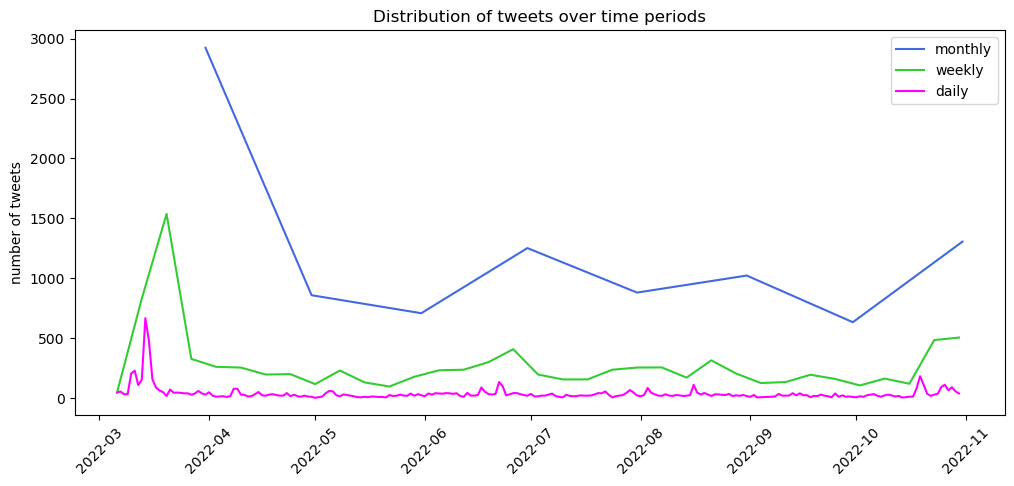

In [23]:
# plotting tweet distributions over time: monthly, weekly, daily

plt.figure(figsize=(12,5))

plt.plot(monthly_tweets['tweets'], c="royalblue", label="monthly")
plt.plot(weekly_tweets['tweets'], c="limegreen", label="weekly")    
plt.plot(daily_tweets['tweets'], c="magenta", label="daily")
plt.xticks(rotation=45)

plt.legend(loc='best')
plt.ylabel("number of tweets")
plt.title("Distribution of tweets over time periods")
plt.show()

**Observation:**
It is observed that tweet number is highest around mid-March, coinciding with an important event when the President visited and camped on the site of the new capital between 13th to 15th March. The graph also shows an increase in tweet number close to end of October. This is another milestone in 2022, when the President launched the virtual capital city in the metaverse.

#### Study the geolocation distribution of tweets

In [50]:
# merge data to get geographical coordinate and place name column

location_content_df = pd.merge(left=content_df, right=tweets_df, how="inner", on="id")
location_content_df=location_content_df[['id','coordinates','place','tweets','sentiment']]
location_content_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8756 entries, 0 to 8755
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           8756 non-null   int64 
 1   coordinates  448 non-null    object
 2   place        448 non-null    object
 3   tweets       8756 non-null   object
 4   sentiment    8756 non-null   object
dtypes: int64(1), object(4)
memory usage: 410.4+ KB


**Observation:**
There are 475 rows with geolocation tags

In [54]:
# keep only rows with coordinates

location_content_df = location_content_df.loc[location_content_df['coordinates'].notnull(),:]
location_content_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448 entries, 72 to 8753
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           448 non-null    int64 
 1   coordinates  448 non-null    object
 2   place        448 non-null    object
 3   tweets       448 non-null    object
 4   sentiment    448 non-null    object
dtypes: int64(1), object(4)
memory usage: 21.0+ KB


**Observation:**
Coordinates and place columns are dictionaries. The next two steps are done to split them into several columns with specific information e.g. longitude, latitude, city name, etc.

In [52]:
# split coordinates into 2 columns: longitude and latitude and concat them back to the dataframe

location_content_df["coordinates"] = location_content_df["coordinates"].apply(lambda x : dict(eval(x)))
lon_lat_df = location_content_df["coordinates"].apply(pd.Series)

geolocation_content_df = pd.concat([location_content_df, lon_lat_df], axis=1).drop('coordinates', axis=1)
geolocation_content_df.head()

id                                              place  \
72  1586266266284662784  {'fullName': 'Medan Petisah, Indonesia', 'name...   
80  1586236330555514880  {'fullName': 'General Affair Sub Department ( ...   
81  1586235315911462913  {'fullName': 'Adi Guna Group', 'name': 'Adi Gu...   
83  1586207720436158465  {'fullName': 'East Borneo, Indonesia', 'name':...   
85  1586204191453638656  {'fullName': 'East Borneo, Indonesia', 'name':...   

                                               tweets sentiment   longitude  \
72  jagatio merupakan platforn dunia virtual perta...             98.644929   
80  info  jagat nusantara tampilkan dunia virtual ...             95.329260   
81  news  jagat nusantara tampilkan dunia virtual ...             95.344720   
83                                               halu            113.836655   
85    penipuan ko semakin masif yasetiap hari ada aja            113.836655   

    latitude  
72  3.601620  
80  5.550990  
81  5.549163  
83 -2.409401  
85 -2.409401

In [53]:
geolocation_content_df['place'].nunique()

155

**Observation:** 
There are 156 unique locations, next step is grouping tweets based on these locations.

In [24]:
# count tweets by unique locations

tweets_counting = geolocation_content_df[['place','tweets']]
tweets_counting=pd.DataFrame(tweets_counting['place'].value_counts())
tweets_counting.reset_index(inplace=True)
tweets_counting

index  place
0    {'fullName': 'Central Borneo, Indonesia', 'nam...     57
1    {'fullName': 'East Borneo, Indonesia', 'name':...     24
2    {'fullName': 'East Nusa Tenggara, Indonesia', ...     15
3    {'fullName': 'Cipondoh, Indonesia', 'name': 'C...     14
4    {'fullName': 'Bali, Indonesia', 'name': 'Bali'...     13
..                                                 ...    ...
150  {'fullName': 'Lempah Kuning Tebing Sampur', 'n...      1
151  {'fullName': 'Papua, Indonesia', 'name': 'Papu...      1
152  {'fullName': 'Adikara Motor', 'name': 'Adikara...      1
153  {'fullName': 'Oakwood Apartments PIK Jakarta',...      1
154  {'fullName': 'Kantor Kesehatan Pelabuhan Kelas...      1

[155 rows x 2 columns]

**Observation:**
Now I have 156 rows of geolocation tagged tweets with tweet counts, but column names are mixed-up. Next steps: (i) correct column names, (ii) extract the location name and plot tweet distribution by locations.

In [25]:
# (i) re-assign column names so that they have correct descriptions

tweets_counting['location']=tweets_counting['index']
tweets_counting['tweet_counts']=tweets_counting['place']
tweets_counting.drop(columns=['index','place'],inplace=True)
tweets_counting

location  tweet_counts
0    {'fullName': 'Central Borneo, Indonesia', 'nam...            57
1    {'fullName': 'East Borneo, Indonesia', 'name':...            24
2    {'fullName': 'East Nusa Tenggara, Indonesia', ...            15
3    {'fullName': 'Cipondoh, Indonesia', 'name': 'C...            14
4    {'fullName': 'Bali, Indonesia', 'name': 'Bali'...            13
..                                                 ...           ...
150  {'fullName': 'Lempah Kuning Tebing Sampur', 'n...             1
151  {'fullName': 'Papua, Indonesia', 'name': 'Papu...             1
152  {'fullName': 'Adikara Motor', 'name': 'Adikara...             1
153  {'fullName': 'Oakwood Apartments PIK Jakarta',...             1
154  {'fullName': 'Kantor Kesehatan Pelabuhan Kelas...             1

[155 rows x 2 columns]

In [26]:
# (ii) extract place name for tweet distribution plotting 

#establish a variable named place_col to contain the contents in 'place' column
place_col=tweets_counting['location']

# break the place contents into separate columns
place = place_col.apply(lambda a : dict(eval(a)))
place_df = place.apply(pd.Series)
place_df

fullName  \
0                      Central Borneo, Indonesia   
1                         East Borneo, Indonesia   
2                  East Nusa Tenggara, Indonesia   
3                            Cipondoh, Indonesia   
4                                Bali, Indonesia   
..                                           ...   
150                  Lempah Kuning Tebing Sampur   
151                             Papua, Indonesia   
152                                Adikara Motor   
153               Oakwood Apartments PIK Jakarta   
154  Kantor Kesehatan Pelabuhan Kelas II Tarakan   

                                            name   type    country countryCode  
0                                 Central Borneo  admin  Indonesia          ID  
1                                    East Borneo  admin  Indonesia          ID  
2                             East Nusa Tenggara  admin  Indonesia          ID  
3                                       Cipondoh   city  Indonesia          ID  
4                                           Bali  admin  Indonesia          ID  
..                                           ...    ...        ...         ...  
150                  Lempah Kuning Tebing Sampur    poi  Indonesia          ID  
151                                        Papua  admin  Indonesia          ID  
152                                Adikara Motor    poi  Indonesia          ID  
153               Oakwood Apartments PIK Jakarta    poi  Indonesia          ID  
154  Kantor Kesehatan Pelabuhan Kelas II Tarakan    poi  Indonesia          ID  

[155 rows x 5 columns]

In [27]:
# Only keep location names and add them back into tweets counting dataframe
tweets_counting['location']=place_df['name']

# Extract top 50 locations
tweets_counting_top = tweets_counting.head(50)

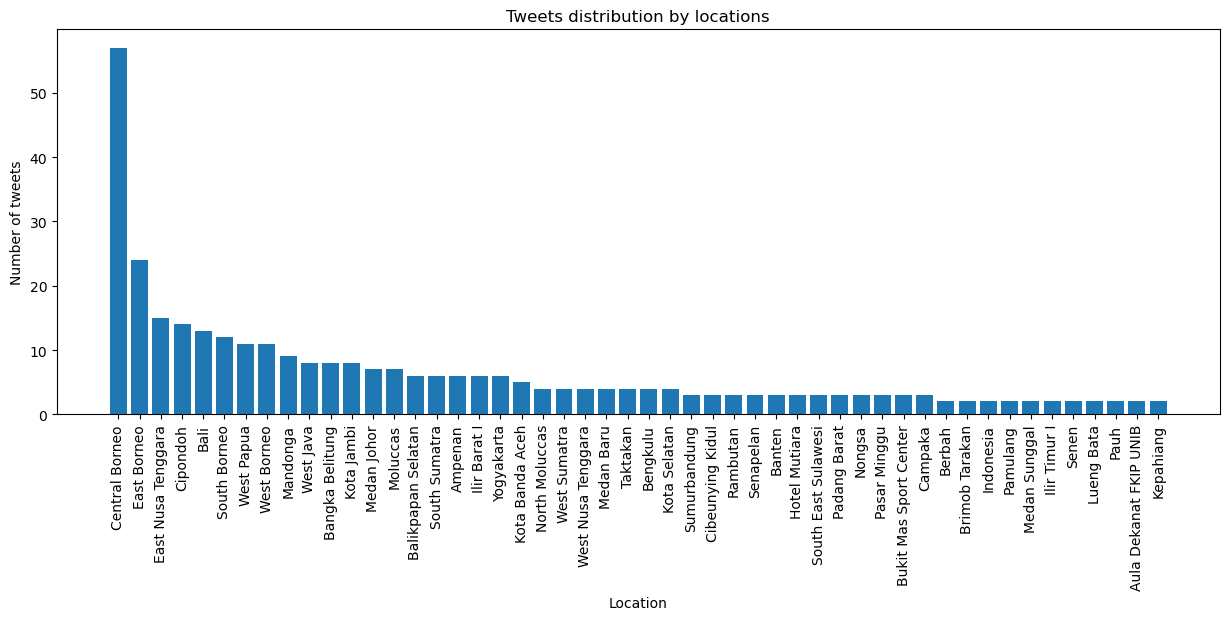

In [28]:
# plot tweet distribution by location

plt.figure(figsize=(15,5))
plt.bar(x='location',height='tweet_counts',data=tweets_counting_top)
plt.title('Tweets distribution by locations')
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Number of tweets')
plt.show()

**Observation:**
Majority tweets come from Central and East Borneo, where the location of new capital is.Jakarta, where the current capital is, is surprisingly not in the top 50 location list.

### EDA 2. Plotting sentiment distribution by time and geolocation

#### Plotting counts of sentiments

In [3]:
# import labeled data

labeled_tweets_df =pd.read_csv('../data/labeled_tweets.csv')
labeled_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8756 entries, 0 to 8755
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8756 non-null   float64
 1   date              8756 non-null   object 
 2   tweets            8756 non-null   object 
 3   processed_tweets  8706 non-null   object 
 4   label             8672 non-null   float64
dtypes: float64(2), object(3)
memory usage: 342.2+ KB


In [4]:
# drop null values and plot sentiment distribution

labeled_tweets_df.dropna(inplace=True)

In [ ]:
# count sentiments

sentiments=labeled_tweets_df.groupby(['label'])['processed_tweets'].count()

In [24]:
sentiments

label
-1.0     303
 0.0    6089
 1.0    2230
Name: processed_tweets, dtype: int64

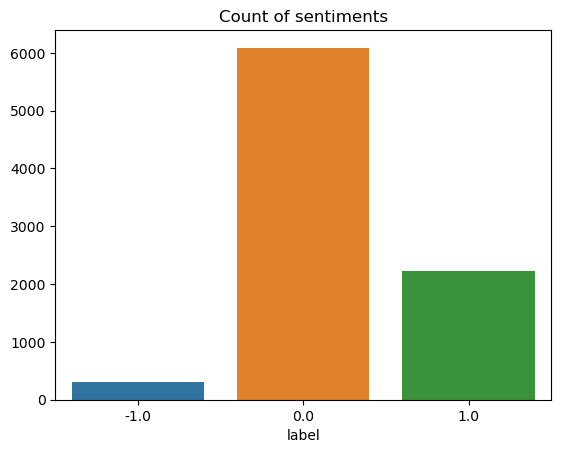

In [25]:
# Plot sentiment counts

sns.barplot(x=sentiments.index, y=sentiments.values)
plt.title('Count of sentiments')
plt.show()

**Observation:**<br>
Imbalanced data observed.

#### Plotting geolocation distribution of sentiments

Geolocation distribution of sentiments and more EDAs are plotted on tableau dashboard, 
available on this [Link](https://public.tableau.com/app/profile/m.alexander8473/viz/capitalrelocationtwitteranalysis/presentation?publish=yes)

### Pre-processing for modeling: plot top words counts, demojize, tokenize and remove stopwords

Stopwords and emojis are not removed on first cleaning (see EDA 1 above) to preserve tweet meanings for the purpose of human annotating. For the purpose of modeling, now second cleaning is conducted to demojize the tweets, and then tokenize and remove stopwords from them.

In [32]:
# define indonesian stopwords using nltk and set language to indonesian

indonesian_stopwords = stopwords.words('indonesian')
len(indonesian_stopwords)

758

#### Plotting top unigrams and bigrams using countvectorizer

In [33]:
# use countvectorizer to check for most common words in corpus 

# Unigram countvectorizer
cvec = CountVectorizer(stop_words = indonesian_stopwords, ngram_range=(1,1))
tweets_cvec = pd.DataFrame(
    cvec.fit_transform(dated_content_df['tweets']).todense(),
    columns = cvec.get_feature_names())

C:\mambo\envs\dsi-sg\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(
C:\mambo\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
# find number of unique words in the whole corpus
len(tweets_cvec.columns)

10218

In [35]:
# find top 20 words
word_count = tweets_cvec.sum().sort_values(ascending=False)
top20_words = word_count[:20]

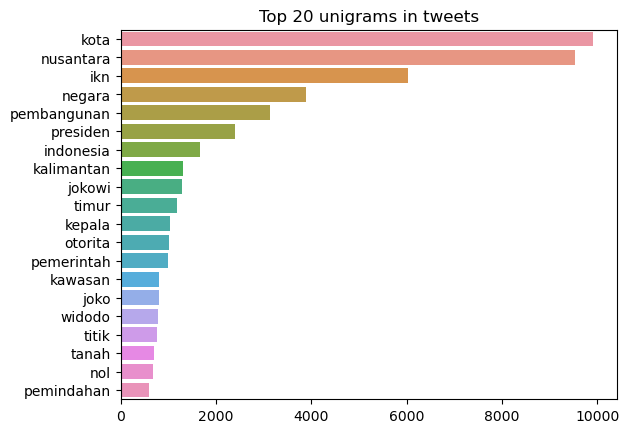

In [36]:
# plot top 20 words
sns.barplot(x=top20_words.values, y=top20_words.index)
plt.title('Top 20 unigrams in tweets')
plt.show()

In [37]:
top_unigrams = pd.DataFrame(columns=['top_unigrams','counts'])
top_unigrams['top_unigrams']=top20_words.index
top_unigrams['counts']=top20_words.values

In [38]:
# Bigram countvectorizer

cvec_2 = CountVectorizer(stop_words = indonesian_stopwords, ngram_range=(2,2))
tweets_cvec_2 = pd.DataFrame(
    cvec_2.fit_transform(dated_content_df['tweets']).todense(),
    columns = cvec_2.get_feature_names())

C:\mambo\envs\dsi-sg\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(
C:\mambo\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [39]:
# find number of unique bigram-words in the whole corpus
print(len(tweets_cvec_2.columns))

# find top 20 words
word_count_2 = tweets_cvec_2.sum().sort_values(ascending=False)
top20_words_2 = word_count_2[:20]

39771


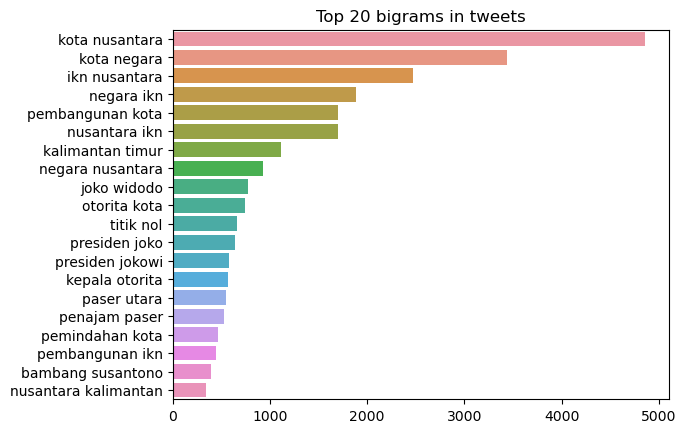

In [40]:
# plot top 20 words
sns.barplot(x=top20_words_2.values, y=top20_words_2.index)
plt.title('Top 20 bigrams in tweets')
plt.show()

In [108]:
top_bigrams = pd.DataFrame(columns=['top_bigrams','counts'])
top_bigrams['top_bigrams']=top20_words_2.index
top_bigrams['counts']=top20_words_2.values

#### Demojize and stop word removal

In [25]:
# remove emojis 
dated_content_df['tweets']=dated_content_df['tweets'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
dated_content_df['tweets']

0       sensasi berada di ibu kota nusantara gimana ya...
1       dengan metaverse bernama jagat nusantara anda ...
2       metaversa memberikan sensasi berada di ibu kot...
3       meski pembangunan ikn baru tahap awal melalui ...
4       meskipun pembangunan ikn baru tahap awalnamun ...
                              ...                        
8751    kepala bin intelligent city di ibu kota negara...
8752    sejarah nusantara yang jadi nama ibu kota baru...
8753              pintu gerbang ibu kota negara nusantara
8754    kerja dengan berbagai pihak dilakukan guna mem...
8755    kabar gembira bagi asn yang akan pindah ke ibu...
Name: tweets, Length: 8756, dtype: object

In [110]:
# define a function to clean text data
def preprocessing(tweet):
 # define indonesian stopwords:
    sw = indonesian_stopwords
 # define topic specific stopwords:  
    add_stop_words = additional_stopwords
 # combine both stopwords lists
    stop_list = sw+add_stop_words 
    
    text = str(tweet)
    if text in stop_list:
        return None
    else:
        return text

In [112]:
# Now, to apply this cleaning function to the text
# define the text:
texts = dated_content_df['tweets']
# split the texts into individual strings:
texts_ls = []
for text in texts:
    texts_ls.append(text.split(" "))       

In [113]:
# loop through texts list to apply the cleaning function and store the results:
text_clean=[]
for text in texts_ls:
    clean = []
    for t in text:
        clean.append(preprocessing(t))
    text_clean.append(clean)

In [115]:
# loop through text clean to remove None values
final_text=[]
for tx in text_clean:
    b=[i for i in tx if i is not None]
    final_text.append(b)

In [117]:
# join them back
final_list=[]
for f in final_text:
    g= ' '.join(map(str, f))
    final_list.append(g)

In [118]:
final_list[:5]

['sensasi gimana ya',
 'metaverse bernama jagat merasakan sensasi',
 'metaversa sensasi bernama jagat',
 'tahap metaverse bernama jagat merasakan sensasi',
 'tahap awalnamun merasakan sensasi metaverse bernama jagat']

In [119]:
dated_content_df['processed_tweets'] = final_list

In [120]:
dated_content_df.head()

id  \
date                              
2022-10-30  1586855500200939520   
2022-10-30  1586855495477841920   
2022-10-30  1586855476364341249   
2022-10-30  1586855472602259457   
2022-10-30  1586855472124108801   

                                                       tweets sentiment  \
date                                                                      
2022-10-30  sensasi berada di ibu kota nusantara gimana ya...             
2022-10-30  dengan metaverse bernama jagat nusantara anda ...             
2022-10-30  metaversa memberikan sensasi berada di ibu kot...             
2022-10-30  meski pembangunan ikn baru tahap awal melalui ...             
2022-10-30  meskipun pembangunan ikn baru tahap awalnamun ...             

                                             processed_tweets  
date                                                           
2022-10-30                                  sensasi gimana ya  
2022-10-30          metaverse bernama jagat merasakan sensasi  
2022-10-30                    metaversa sensasi bernama jagat  
2022-10-30    tahap metaverse bernama jagat merasakan sensasi  
2022-10-30  tahap awalnamun merasakan sensasi metaverse be...

In [55]:
# export data to csv

dated_content_df.to_csv('../data/dated_processed_tweets.csv')
geolocation_content_df.to_csv('../data/geography.csv', index=False)
tweets_counting_top.to_csv('../data/tweets_counting.csv',index=False)

#### Continuing to notebook 3 for modeling